In [1]:
from sklearn import linear_model
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm

import itertools
import matplotlib.image as mpimg

from scipy.stats import poisson

In [2]:
#bibliotecas para os modelos
from sklearn.metrics import accuracy_score, log_loss,confusion_matrix, roc_curve, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures


In [3]:
df_ranking = pd.read_csv('fifa_ranking_save_2.csv') #dados do ranking de seleções da FIFA até 2018
df_partidas_internacionais = pd.read_csv('results_save_2.csv') #dados de partidas internacionais até 2022
df_last_world_cup = pd.read_csv('world_cup2018_save_2.csv') #dados da copa de 2018

#dados do elo rating criado a partir dos histórico de partidas internacionais da FIFA para as seleções até 2022
df_times_elo_rating = pd.read_csv('df_times_elo_rating_save.csv')

ranking_copa_2022 = pd.read_csv('ranking_copa_2022_save_2.csv') #ranking das seleções da copa de 2022
df_copa_2022 = pd.read_csv('copa_2022_save_2.csv') #dados da copa de 2022

## Modelo

Primeiro é importante adicionarmos uma coluna de peso que é baseada na data do jogo porque é óbvio que um jogo que aconteceu este ano tem mais peso do que o primeiro jogo em 1872.


Em seguida, crio os dados para o modelo que é composto por 4 colunas: time, adversário, gols e peso.

In [8]:
df_partidas_internacionais['date'] = df_partidas_internacionais['date'].astype('datetime64[ms]')

In [9]:
def peso_por_torneios(torneios):
    if 'Cup' in torneios or 'Euro' in torneios:
        return 1
    else :
        return 100

# Create weight column based on the date
df_partidas_internacionais.loc[:,'weight'] = df_partidas_internacionais['tournament'].apply(peso_por_torneios)
df_partidas_internacionais.loc[:,'weight'] = 1 / ((2022 - df_partidas_internacionais['date'].dt.year.astype('int64'))*df_partidas_internacionais['weight'])

# Create model data
matches_model_data = pd.concat([df_partidas_internacionais[['home_team','away_team','home_score','weight']].rename(
            columns={'home_team':'team', 'away_team':'opponent','home_score':'goals'}),
            df_partidas_internacionais[['away_team','home_team','away_score','weight']].rename(
            columns={'away_team':'team', 'home_team':'opponent','away_score':'goals'})])

In [10]:
matches_model_data

,team,opponent,goals,weight
0,Bolivia,Uruguay,3,0.034483
1,Brazil,Mexico,1,0.000345
2,Ecuador,Venezuela,5,0.034483
3,Guinea,Sierra Leone,1,0.000345
4,Paraguay,Argentina,1,0.034483
...,...,...,...,...
18643,Uzbekistan,Uruguay,0,0.002500
18644,Algeria,Portugal,0,0.002500
18645,Bolivia,Korea Republic,0,0.002500
18646,Ghana,Iceland,2,0.002500


In [11]:
#matches_model_data = matches_model_data.fillna(0)

In [12]:
#matches_model_data.replace([np.inf, -np.inf], np.nan, inplace=True)

In [13]:
#matches_model_data.dropna(subset=["weight"], how="all", inplace=True)

In [14]:
matches_model_data.team.unique()

array(['Bolivia', 'Brazil', 'Ecuador', 'Guinea', 'Paraguay', 'Peru',
       'Faroe Islands', 'Sweden', 'Australia', 'Colombia', 'Congo',
       'Uruguay', 'Argentina', 'Austria', 'Denmark', 'Iceland', 'Estonia',
       'Albania', 'Bulgaria', 'England', 'Finland', 'Hungary',
       'Republic of Ireland', 'Northern Ireland', 'Norway', 'Scotland',
       'Spain', 'Venezuela', 'Morocco', 'Saudi Arabia', 'Zimbabwe',
       'Mexico', 'Romania', 'San Marino', 'Tunisia', 'Korea Republic',
       'Zambia', 'Cyprus', 'Belgium', 'Algeria', 'Cameroon', 'Luxembourg',
       'France', 'Germany', 'Italy', 'Netherlands', 'Poland', 'Portugal',
       'United States', 'Wales', 'Iran', 'Japan', 'Iraq', 'Burundi',
       'Liechtenstein', 'United Arab Emirates', 'Israel', 'Turkey',
       'Egypt', 'Gabon', 'Greece', 'Malta', 'Switzerland', 'Gambia',
       'Sierra Leone', 'Guinea-Bissau', 'Senegal', 'Mali', 'Ghana',
       'Tahiti', 'Kenya', 'Tanzania', 'Bangladesh', 'Barbados',
       'Mauritania', 'Thail

### Modelo de poisson

O modelo de poisson será utilizado tendo em vista que cada equipe segue a distribuição de Poisson com base no número de jogos. Onde o time da casa marcou mais gols do que o time visitante. 

A regressão de Poisson é normalmente usada para conjuntos de dados em que a resposta representa contagens e os erros são considerados como tendo uma distribuição de Poisson. Em geral, pode ser aplicado a qualquer dado em que a resposta seja não negativa. Ele modela a dependência entre a resposta e as covariáveis como:

colocar formulás que está no site sobre o algoritmo: https://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/glm.html

Então aqui usando as bibliotecas statsmodels eu crio meu modelo com uma regressão de Poisson.

In [15]:
poisson_model = smf.glm(formula="goals ~ team + opponent", data=matches_model_data, 
                        family=sm.families.Poisson(), freq_weights=matches_model_data['weight'].values).fit()  #freq_weights=matches_model_data['weight'].values

In [73]:
poisson_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  goals   No. Observations:                35766
Model:                            GLM   Df Residuals:                  1230.57
Model Family:                 Poisson   Df Model:                          388
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2253.1
Date:                Mon, 27 Jun 2022   Deviance:                       1841.4
Time:                        19:02:35   Pearson chi2:                 1.69e+03
No. Iterations:                     6   Pseudo R-squ. (CS):            0.02286
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                                0.1844      0.452      0.408      0.683      -0.701       1.070
team[T.Albania]                          0.9531      0.520      1.834      0.067      -0.066       1.972
team[T.Algeria]                          1.2186      0.470      2.590      0.010       0.297       2.141
team[T.American Samoa]                  -1.3313      1.003     -1.327      0.184      -3.297       0.635
team[T.Andorra]                         -0.3984      0.817     -0.488      0.626      -1.999       1.202
team[T.Angola]                           0.7960      0.493      1.614      0.106      -0.170       1.763
team[T.Anguilla]                        -0.6623      1.252     -0.529      0.597      -3.116       1.792
team[T.Antigua and Barbuda]              0.3988      0.645      0.618      0.537      -0.866       1.664
team[T.Argentina]                        1.7338      0.459      3.773      0.000       0.833       2.634
team[T.Armenia]                          0.9865      0.525      1.878      0.060      -0.043       2.016
team[T.Aruba]                            0.4265      0.747      0.571      0.568      -1.038       1.891
team[T.Australia]                        1.3913      0.407      3.417      0.001       0.593       2.189
team[T.Austria]                          1.4648      0.463      3.164      0.002       0.558       2.372
team[T.Azerbaijan]                       0.5903      0.563      1.049      0.294      -0.512       1.693
team[T.Bahamas]                          0.0451      0.882      0.051      0.959      -1.684       1.774
team[T.Bahrain]                          0.8602      0.421      2.044      0.041       0.036       1.685
team[T.Bangladesh]                      -0.4774      0.529     -0.903      0.367      -1.514       0.559
team[T.Barbados]                         0.3250      0.631      0.515      0.606      -0.912       1.562
team[T.Belarus]                          0.9546      0.520      1.835      0.066      -0.065       1.974
team[T.Belgium]                          1.6473      0.439      3.756      0.000       0.788       2.507
team[T.Belize]                           0.3538      0.714      0.495      0.620      -1.046       1.754
team[T.Benin]                            0.9618      0.551      1.747      0.081      -0.117       2.041
team[T.Bermuda]                          0.5594      0.646      0.866      0.387      -0.707       1.826
team[T.Bhutan]                          -0.6416      0.623     -1.029      0.303      -1.863       0.580
team[T.Bolivia]                          1.4046      0.514      2.732      0.006       0.397       2.412
team[T.Bosnia and Herzegovina]           1.4470      0.447      3.240      0.001       0.572       2.322
team[T.Botswana]                      

Agora é hora de fazer uma função que possa retornar o resultado de um jogo, existem algumas informações que precisamos saber:

As duas equipes
Se a partida é uma eliminação ou não (se True não podemos retornar um resultado de empate)
O máximo de empate que indicará quantos empates faremos para o jogo. Quanto maior for este número, o resultado será principalmente o resultado com maior probabilidade.
O máximo de gols no jogo
Então, primeiro eu defino a função que será uma tupla de dois arrays:

Um array com as 3 probabilidades do time 1 ganhar, um jogo empatado e o time 2 ganhar.
Uma matriz com as probabilidades de pontuação para cada equipe

In [173]:
def get_proba_match(foot_model, team1, team2, max_goals=10):
    # Get the average goal for each team
    t1_goals_avg = foot_model.predict(pd.DataFrame(data={'team': team1, 'opponent': team2}, index=[1])).values[0]
    t2_goals_avg = foot_model.predict(pd.DataFrame(data={'team': team2, 'opponent': team1}, index=[1])).values[0]
    
    # Get probability of all possible score for each team
    team_pred = [[poisson.pmf(i, team_avg) for i in range(0, max_goals+1)] for team_avg in [t1_goals_avg, t2_goals_avg]]
    
    #todos as probabilidades de resultados possiveis
    match = np.outer(np.array(team_pred[0]), np.array(team_pred[1]))
    
    # Get the proba for each possible outcome
    t1_wins = np.sum(np.tril(match, -1))
    draw = np.sum(np.diag(match))
    t2_wins = np.sum(np.triu(match, 1))
    result_proba = [t1_wins, draw, t2_wins]
    
    # Adjust the proba to sum to one
    result_proba =  np.array(result_proba)/ np.array(result_proba).sum(axis=0,keepdims=1)
    team_pred[0] = np.array(team_pred[0])/np.array(team_pred[0]).sum(axis=0,keepdims=1)
    team_pred[1] = np.array(team_pred[1])/np.array(team_pred[1]).sum(axis=0,keepdims=1)
    return result_proba, [np.array(team_pred[0]), np.array(team_pred[1])], match

Agora posso fazer a função que nos dará o resultado do jogo. Ele retornará o resultado primeiro (o vencedor ou empate), o perdedor (será 'empate' se for um resultado de empate) e a pontuação de cada equipe. Além das chances de vítoria, derrota e empate somando todos os resultados possíveis.

In [258]:
def get_match_result(foot_model, team1, team2, elimination=False, max_draw=50, max_goals=10):
    # Get the proba
    proba,score_proba, match = get_proba_match(foot_model, team1, team2, max_goals)
    
    # Get the result, if it's an elimination game we have to be sure the result is not draw
    results = pd.Series([np.random.choice([team1, 'draw', team2], p=proba) for i in range(0,max_draw)]).value_counts()
    result = results.index[0] if not elimination or (elimination and results.index[0] != 'draw') else results.index[1]
    
    # If the result is not a draw game then we calculate the score of the winner from 1 to the max_goals 
    # and the score of the looser from 0 to the score of the winner
    if (result != 'draw'): 
        i_win, i_loose = (0,1) if result == team1 else (1,0)
        score_proba[i_win] = score_proba[i_win][1:]/score_proba[i_win][1:].sum(axis=0,keepdims=1)
        winner_score = pd.Series([np.random.choice(range(1, max_goals+1), p=score_proba[i_win]) for i in range(0,max_draw)]).value_counts().index[0]
        
        score_proba[i_loose] = score_proba[i_loose][:winner_score]/score_proba[i_loose][:winner_score].sum(axis=0,keepdims=1)
        looser_score = pd.Series([np.random.choice(range(0, winner_score), p=score_proba[i_loose]) for i in range(0,max_draw)]).value_counts().index[0]
        
        
        score = [winner_score, looser_score]
        
      
    # If it's a draw then we calculate a score and repeat it twice
    else:
        score = np.repeat(pd.Series([np.random.choice(range(0, max_goals+1), p=score_proba[0]) for i in range(0,max_draw)]).value_counts().index[0],2)
    looser = team2 if result == team1 else team1 if result != 'draw' else 'draw'
    
    
    t1_wins = round(np.sum(np.tril(match, -1)),2)
    draw = round(np.sum(np.diag(match)),2)
    t2_wins = round(np.sum(np.triu(match, 1)),2)
        
    porcent = (f'Chances de vitória {team1}: {t1_wins}%, chances de empate: {draw}%, chances de vitória {team2}: {t2_wins}%')
        
    
    return result, looser, score, porcent

Agora vamos tentar!

In [259]:
print(get_match_result(poisson_model, 'Spain', 'Brazil'))

('Spain', 'Brazil', [1, 0], 'Chances de vitória Spain: 0.34%, chances de empate: 0.28%, chances de vitória Brazil: 0.39%')


In [245]:
print(get_match_result(poisson_model, 'United States', 'England'))

('England', 'United States', [1, 0], 'Chances de vitória United States: 0.23309693850625807, chances de empate: 0.2737479587533004, chances de vitória England: 0.4931548274270149')


In [119]:
teste = simulate_match2(poisson_model, "Spain", "Brazil", max_goals=10)
teste

[0.336380969829413, 0.27680180308658303, 0.38681709747878446]

In [101]:
teste = simulate_match2(poisson_model, "Spain", "Brazil", max_goals=10)
teste

[0.336380969829413, 0.27680180308658303, 0.38681709747878446]

### Simulando os jogos

É hora de fazer a competição! Primeiro vamos criar os grupos seguindo os grupos da copa e que já vimos anteriormente:

In [20]:
groupA = ['Qatar', 'Senegal', 'Netherlands', 'Ecuador']
groupB = ['England', 'Iran','United States', 'Wales']
groupC = ['Argentina', 'Saudi Arabia', 'Mexico', 'Poland']
groupD = ['France', 'Australia', 'Denmark', 'Tunisia']
groupE = ['Spain', 'Costa Rica','Germany', 'Japan']
groupF = ['Belgium', 'Canada', 'Morocco', 'Croatia']
groupG = ['Brazil', 'Serbia', 'Switzerland', 'Cameroon']
groupH = ['Portugal', 'Ghana','Uruguay', 'Korea Republic']
groups = [groupA, groupB, groupC, groupD, groupE, groupF, groupG, groupH]

Agora eu crio 2 funções: uma para o resultado do grupo e outra para o resultado final.

In [21]:
def get_group_result(foot_model, group):
    ranking = pd.DataFrame({'points':[0,0,0,0], 'diff':[0,0,0,0], 'goals':[0,0,0,0]}, index=group)
    for team1, team2 in itertools.combinations(group, 2):
        result, looser, score, porcent = get_match_result(foot_model, team1, team2)
        #print(result, '-', looser,':', score)
        if result == 'draw':
            ranking.loc[[team1, team2], 'points'] += 1
            ranking.loc[[team1, team2], 'goals'] += score[0]
        else:
            ranking.loc[result, 'points'] += 3
            ranking.loc[result, 'goals'] += score[0]
            ranking.loc[looser, 'goals'] += score[1]
            ranking.loc[result, 'diff'] += score[0]-score[1]
            ranking.loc[looser, 'diff'] -= score[0]-score[1]
            
    return ranking.sort_values(by=['points','diff','goals'], ascending=False)

In [22]:
def get_final_result(foot_model, groups_result):
    round_of_16 = []
    quarter_finals = []
    semi_finals = []
    
    # SIMULATE ROUND OF 16
    for i in range(0, 8, 2):
        round_of_16.append(get_match_result(foot_model, groups_result[i].index[0], groups_result[i+1].index[1], elimination=True))
        round_of_16.append(get_match_result(foot_model, groups_result[i].index[1], groups_result[i+1].index[0], elimination=True))
    
    # SIMULATE QUATER FINALS
    quarter_finals.append(get_match_result(foot_model, round_of_16[0][0], round_of_16[2][0], elimination=True))
    quarter_finals.append(get_match_result(foot_model, round_of_16[1][0], round_of_16[3][0], elimination=True))
    quarter_finals.append(get_match_result(foot_model, round_of_16[4][0], round_of_16[6][0], elimination=True))
    quarter_finals.append(get_match_result(foot_model, round_of_16[5][0], round_of_16[7][0], elimination=True))
    
    # SIMULATE SEMI FINALS
    semi_finals.append(get_match_result(foot_model, quarter_finals[0][0], quarter_finals[2][0], elimination=True))
    semi_finals.append(get_match_result(foot_model, quarter_finals[1][0], quarter_finals[3][0], elimination=True))
    
    # SIMULATE 3RD PLACE MATCH
    little_final = get_match_result(foot_model, semi_finals[0][1], semi_finals[1][1], elimination=True)
    
    # SIMULATE FINAL
    final = get_match_result(foot_model, semi_finals[0][0], semi_finals[1][0], elimination=True)
    
    return round_of_16, quarter_finals, semi_finals, little_final, final

E assim as próximas 4 linhas nos darão todo o resultado da competição!

In [23]:
groups_ranking = []
for group in groups:
    groups_ranking.append(get_group_result(poisson_model, group))

round_of_16, quarter_finals, semi_finals, little_final, final = get_final_result(poisson_model, groups_ranking)

Vamos visualizar o resultado da competição. Primeiro vamos dar uma olhada no resultado dos grupos com os diferentes rankings.

In [24]:
for group_rank in groups_ranking:
    display(group_rank)

,points,diff,goals
Netherlands,9,4,4
Ecuador,6,2,3
Senegal,3,-1,1
Qatar,0,-5,0


,points,diff,goals
England,9,3,3
Iran,4,0,1
United States,4,0,1
Wales,0,-3,0


,points,diff,goals
Argentina,9,3,3
Mexico,6,2,3
Poland,3,-2,1
Saudi Arabia,0,-3,0


,points,diff,goals
France,9,3,3
Denmark,6,1,2
Australia,3,-1,1
Tunisia,0,-3,0


,points,diff,goals
Spain,9,4,4
Germany,6,2,3
Costa Rica,3,-2,1
Japan,0,-4,0


,points,diff,goals
Croatia,9,3,3
Belgium,6,2,3
Morocco,3,-1,1
Canada,0,-4,0


,points,diff,goals
Brazil,9,6,6
Switzerland,6,0,2
Serbia,3,-2,2
Cameroon,0,-4,1


,points,diff,goals
Uruguay,9,4,4
Portugal,6,1,2
Ghana,3,-1,1
Korea Republic,0,-4,0


ta faltando o cálculo do resultado final e entender como é realizada essa imagem dos resultados finais abaixo:

Agora podemos fazer o resultado final em um enredo incrível:

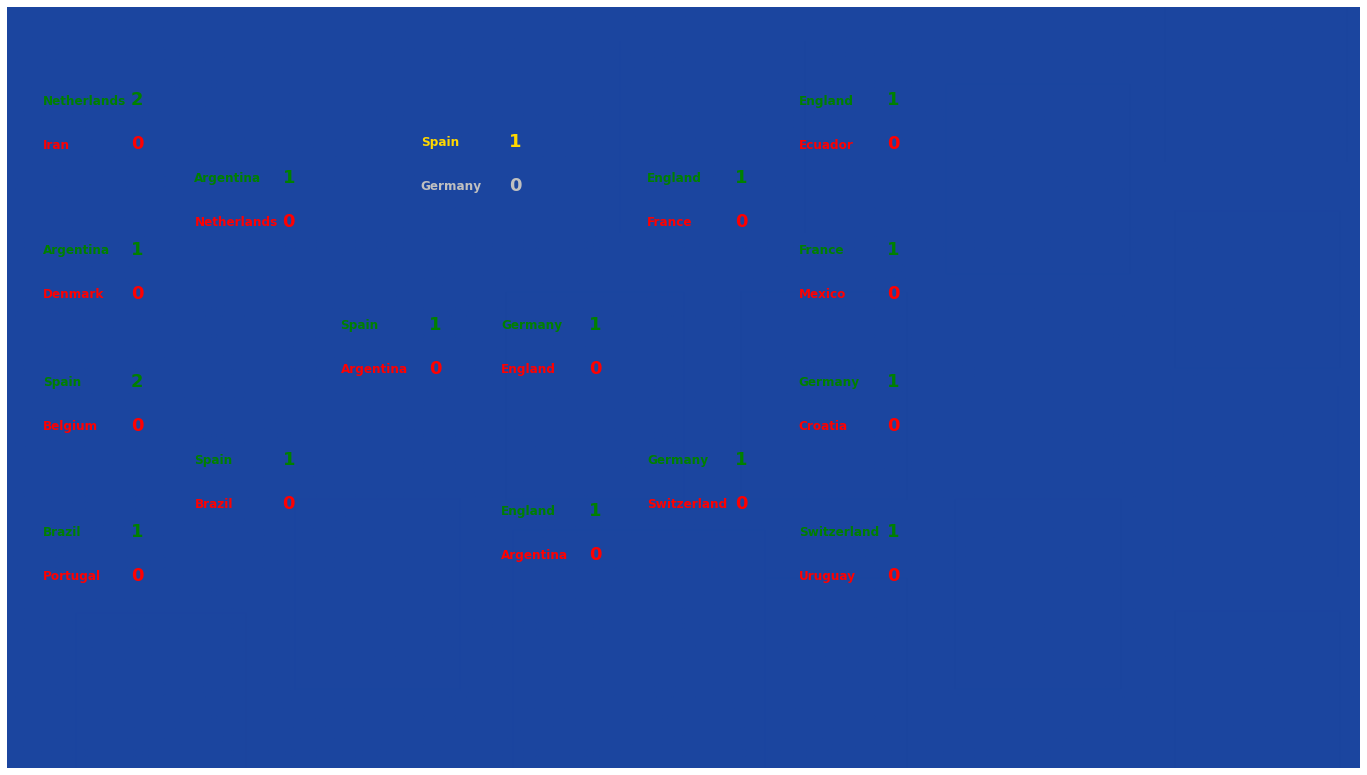

In [25]:
plt.figure(figsize = (25,14))
img = mpimg.imread('tabela.png')
plt.imshow(img)
plt.axis('off')

def text_match(x, y, match, final=False):
    col_win, col_loose = ('green', 'red') if (not final) else ('gold', 'silver')
    plt.text(x, y, match[0], fontsize=12, color=col_win, weight='bold')
    plt.text(x+100, y+1, match[2][0], fontsize=18, color=col_win, weight='bold')
    plt.text(x, y+50, match[1], fontsize=12, color=col_loose, weight='bold')
    plt.text(x+100, y+51, match[2][1], fontsize=18, color=col_loose, weight='bold')


round_of_16_xy = [(40,110),(898,110),(40,280),(898,280),(40,430),(898,430),(40,600),(898,600)]
quarter_finals_xy = [(212,198),(726,198),(212,518),(726,518)]
semi_finals_xy = [(378,365),(560,365)]
x_little_final, y_little_final = 560, 576
x_final, y_final = 469, 157

for (x, y), match in zip(round_of_16_xy, round_of_16):
    text_match(x, y, match)
for (x, y), match in zip(quarter_finals_xy, quarter_finals):
    text_match(x, y, match)
for (x, y), match in zip(semi_finals_xy, semi_finals):
    text_match(x, y, match)
text_match(x_little_final, y_little_final, little_final)
text_match(x_final, y_final, final, final=True)
plt.show()

In [27]:
import pickle

with open('poisson_model.pkl', 'wb') as file:
    pickle.dump(poisson_model, file)

## Modelo 2 (AutoML) - Divisão 

In [12]:
df_partidas_internacionais.date.isna().sum()

0

In [13]:
X, y = df_partidas_internacionais.loc[:,['average_rank', 'rank_difference', 'point_difference','elo_difference', 'is_stake']], df_partidas_internacionais['is_won']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Construindo o modelo

In [14]:
log_cols = ["Classifier", "Accuracy"]
log = pd.DataFrame(columns=log_cols)
acc_dict = {}

### Aplicar técnica para testar diferentes hiperparâmetros e testar diferentes modelos

In [15]:
classifiers = [
    KNeighborsClassifier(3),
    SVC(probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    LogisticRegression(),
    XGBClassifier(),
    LGBMClassifier(),
]

O que irei fazer agora é uma espécie de AutoML

/home/luis/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/luis/.local/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[01:34:26] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/tmp/ipykernel_5292/1400548870.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log = log.append(log_entry)
/tmp/ipykernel_5292/1400548870.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log = log.append(log_entry)
/tmp/ipykernel_5292/1400548870.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log = log.append(log_entry)
/tmp/ipykernel_5292/1400548870.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log = log.append(log_entry)
/tmp/ipykernel_5292/1400548870.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log = log.append(log_en

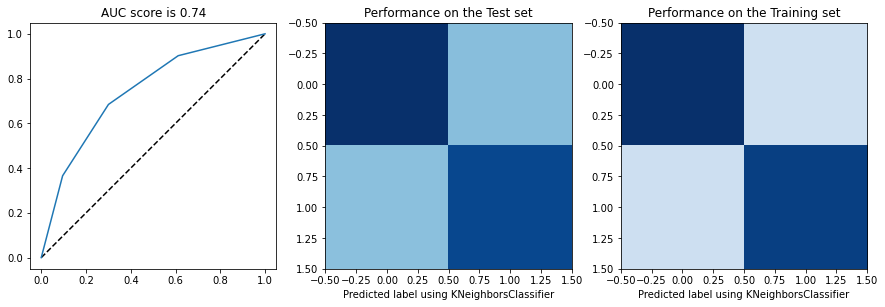

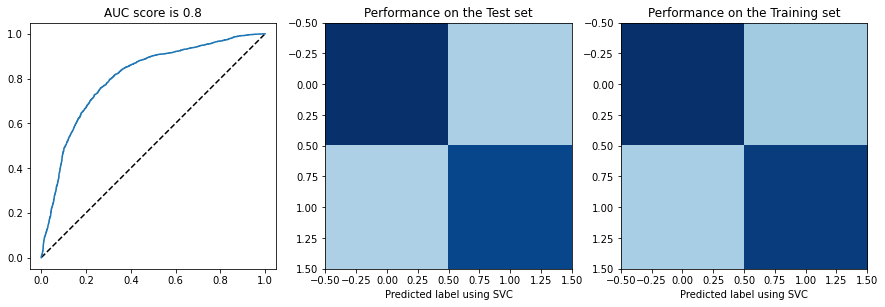

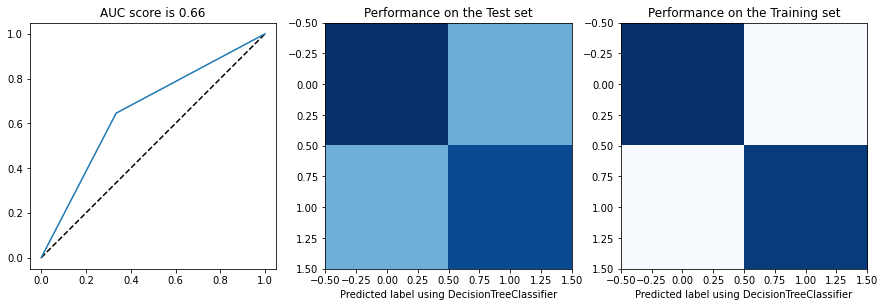

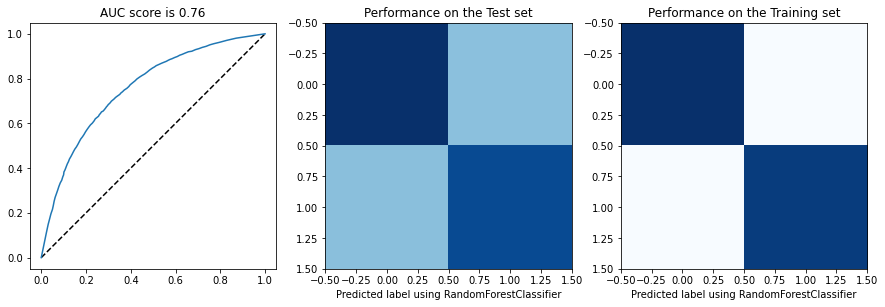

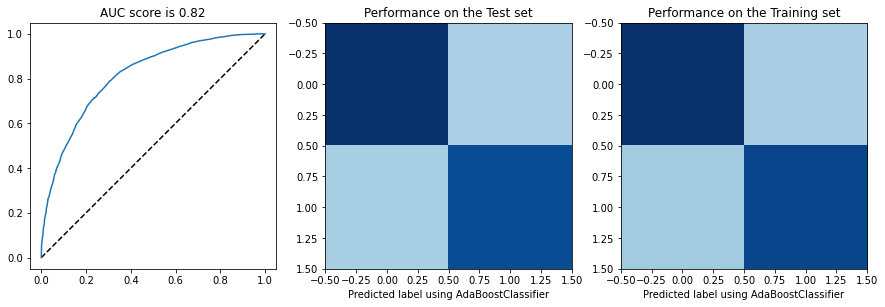

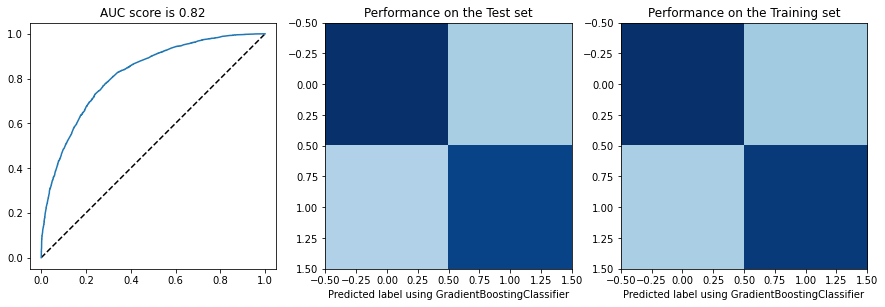

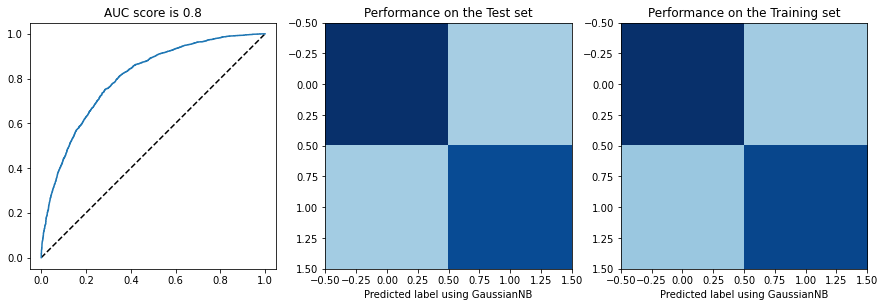

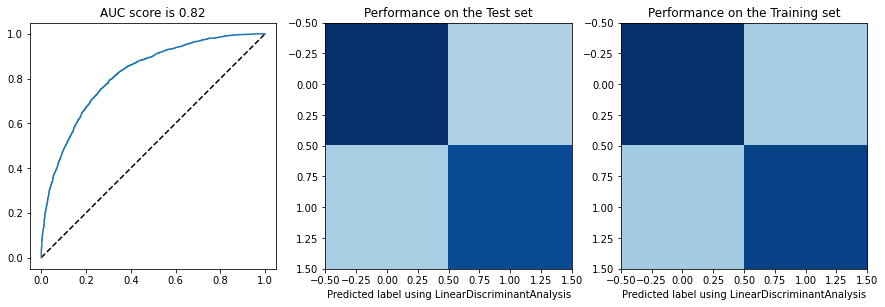

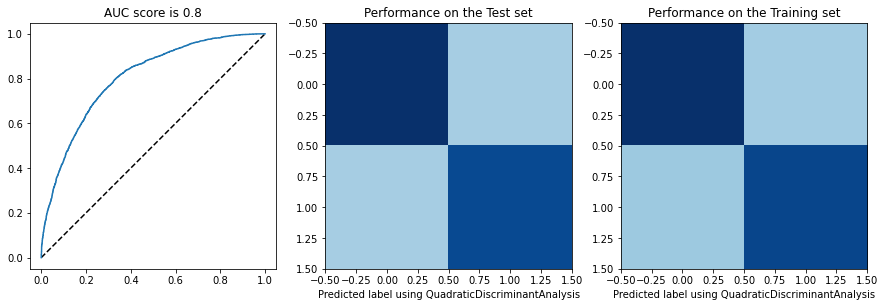

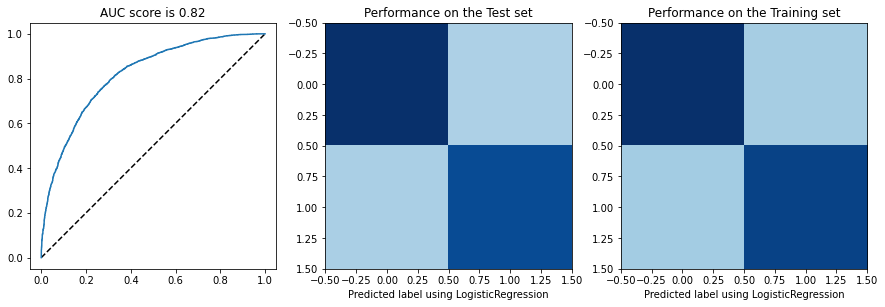

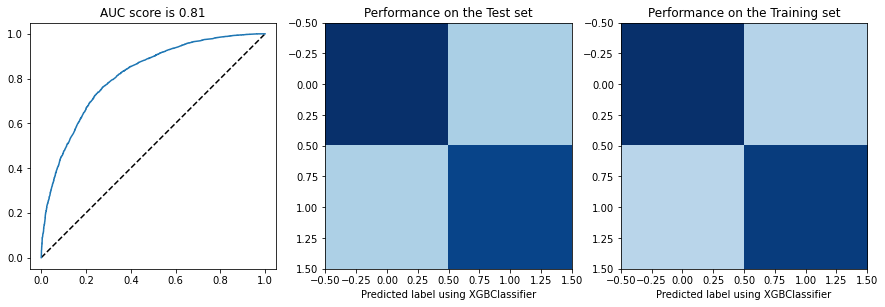

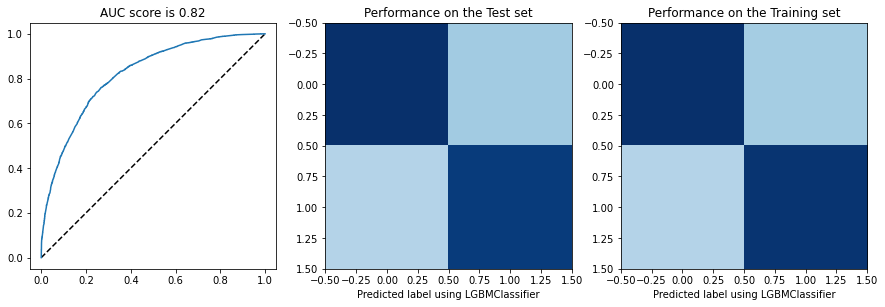

In [16]:
# Loop para fazer o ajuste e as previsões de cada classificador no conjunto de dados
for clf in classifiers:
    name = clf.__class__.__name__
    clf.fit(X_train, y_train)
    train_predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, train_predictions)
    # figures 
    fpr, tpr, _ = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
    plt.figure(figsize=(15,5))
    ax = plt.subplot(1,3,1)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.plot(fpr, tpr)
    ax.set_title('AUC score is {0:0.2}'.format(roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])))
    ax.set_aspect(1)

    ax = plt.subplot(1,3,2)
    cm = confusion_matrix(y_test, clf.predict(X_test))
    ax.imshow(cm, cmap='Blues', clim = (0, cm.max())) 

    ax.set_xlabel('Predicted label using ' + name)
    ax.set_title('Performance on the Test set')

    ax = plt.subplot(1,3,3)
    cm = confusion_matrix(y_train, clf.predict(X_train))
    ax.imshow(cm, cmap='Blues', clim = (0, cm.max())) 
    ax.set_xlabel('Predicted label using ' + name)
    ax.set_title('Performance on the Training set')
    pass
    
    # Storing each score into a dict
    if name in acc_dict:
        acc_dict[name] += acc
    else:
        acc_dict[name] = acc

# Storing the results in a DataFrame to be visualized
for clf in acc_dict:
    acc_dict[clf] = acc_dict[clf] / 10.0
    log_entry = pd.DataFrame([[clf, acc_dict[clf]]], columns=log_cols)
    log = log.append(log_entry)

### defindo modelos que utilizados para a previsão 

MELHORAR OS HIPERPARÂMETROS APLICANDO AS TÉCNICAS QUE APRENDI

In [17]:
gb_model = GradientBoostingClassifier()
gb_model.fit(X_train, y_train)

qda_model = QuadraticDiscriminantAnalysis()
qda_model.fit(X_train, y_train)

xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)

/home/luis/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/luis/.local/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[01:35:00] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

## Avaliando o modelo 

## Simulação de vencedores dos jogos da fase de grupo

In [18]:
df_copa_2022 = df_copa_2022[['Team', 'Grupo', 'Primeiro confronto',
       'Segundo confronto', 'Terceiro confronto']].copy()

In [19]:
#df_times_elo_rating = df_times_elo_rating[['team', 'elo']].copy()
df_times_elo_rating.rename(columns = {'team':'Team'}, inplace = True)

In [20]:
from itertools import combinations

opponents = ['Primeiro confronto', 'Segundo confronto', 'Terceiro confronto']
margin = 0.05
df_copa_2022['points'] = 0
df_copa_2022['total_prob'] = 0

for grupo in sorted(set(df_copa_2022['Grupo'])):
    print('___Grupo {}:___'.format(grupo))
    for home, away in combinations(df_copa_2022.query('Grupo == "{}"'.format(grupo)).index, 2):
        print("{} vs. {}: ".format(home, away), end='')
        
        row = pd.DataFrame(np.array([[np.nan, np.nan, np.nan, np.nan, True]]), columns=X_test.columns)
       
        home_rank = ranking_copa_2022.loc[home, 'rank']
        home_points = ranking_copa_2022.loc[home, 'total_points']
        home_elo = ranking_copa_2022.loc[home, 'elo_ratings']
        opp_rank = ranking_copa_2022.loc[away, 'rank']
        opp_points = ranking_copa_2022.loc[away, 'total_points']
        opp_elo = ranking_copa_2022.loc[away, 'elo_ratings']
        
        row['average_rank'] = (home_rank + opp_rank) / 2
        row['rank_difference'] = home_rank - opp_rank
        row['point_difference'] = home_points - opp_points
        row['elo_difference'] = home_elo - opp_elo
        
        home_win_prob = qda_model.predict_proba(row)[:,1][0] * 0.5 + xgb_model.predict_proba(row)[:,1][0] * 0.5
        df_copa_2022.loc[home, 'total_prob'] += home_win_prob
        df_copa_2022.loc[away, 'total_prob'] += 1-home_win_prob
        
        points = 0
        if home_win_prob <= 0.5 - margin:
            print("{} wins with {:.2f}".format(away, 1-home_win_prob))
            df_copa_2022.loc[away, 'points'] += 3
        if home_win_prob > 0.5 - margin:
            points = 1
        if home_win_prob >= 0.5 + margin:
            points = 3
            df_copa_2022.loc[home, 'points'] += 3
            print("{} wins with {:.2f}".format(home, home_win_prob))
        if points == 1:
            print("Draw")
            df_copa_2022.loc[home, 'points'] += 1
            df_copa_2022.loc[away, 'points'] += 1

___Grupo A:___
0 vs. 1: 1 wins with 0.92
0 vs. 2: 2 wins with 0.64
0 vs. 3: 0 wins with 0.78
1 vs. 2: 1 wins with 0.88
1 vs. 3: 1 wins with 0.98
2 vs. 3: 2 wins with 0.81
___Grupo B:___
4 vs. 5: 5 wins with 0.63
4 vs. 6: 4 wins with 0.81
4 vs. 7: 4 wins with 0.66
5 vs. 6: 5 wins with 0.75
5 vs. 7: 5 wins with 0.77
6 vs. 7: 7 wins with 0.64
___Grupo C:___
8 vs. 9: 9 wins with 0.71
8 vs. 10: 8 wins with 0.61
8 vs. 11: 8 wins with 0.63
9 vs. 10: 9 wins with 0.58
9 vs. 11: Draw
10 vs. 11: 10 wins with 0.55
___Grupo D:___
12 vs. 13: 13 wins with 0.96
12 vs. 14: 14 wins with 0.78
12 vs. 15: 15 wins with 0.98
13 vs. 14: 13 wins with 0.63
13 vs. 15: 15 wins with 0.74
14 vs. 15: 15 wins with 0.87
___Grupo E:___
16 vs. 17: 16 wins with 0.89
16 vs. 18: 16 wins with 0.81
16 vs. 19: 16 wins with 0.95
17 vs. 18: 18 wins with 0.75
17 vs. 19: 17 wins with 0.64
18 vs. 19: 18 wins with 0.81
___Grupo F:___
20 vs. 21: 21 wins with 0.98
20 vs. 22: 22 wins with 1.00
20 vs. 23: 23 wins with 0.97
21 vs. 22: 2

In [26]:
df_copa_2022['Team'] = df_copa_2022['Team'].astype("str")

In [27]:
df_copa_2022.head()

,index,Team,Grupo,Primeiro confronto,Segundo confronto,Terceiro confronto,points,total_prob
0,30,Uruguay,H,Korea Republic,Portugal,Ghana,7,2.202455
1,28,Portugal,H,Ghana,Uruguay,Korea Republic,7,2.056368
2,31,Korea Republic,H,Uruguay,Ghana,Portugal,3,1.421687
3,29,Ghana,H,Portugal,Korea Republic,Uruguay,0,0.319491
4,25,Serbia,G,Brazil,Cameroon,Switzerland,9,2.820092


In [28]:
pairing = [0,3,4,7,8,11,12,15,1,2,5,6,9,10,13,14]

df_copa_2022 = df_copa_2022.sort_values(by=['Grupo', 'points', 'total_prob'], ascending=False).reset_index()
next_round_wc = df_copa_2022.groupby('Grupo').nth([0, 1]) # select the top 2
next_round_wc = next_round_wc.reset_index()
print("_____Qualified Teams______\n")
print(next_round_wc.loc[:,['Grupo','Team','points','total_prob']])
print("\n")
next_round_wc = next_round_wc.loc[pairing]
next_round_wc = next_round_wc.set_index('Team')

print("_____Knockout Phase______")
finals = ['Round_of_16', 'Quarterfinal', 'Semifinal', 'Final']

labels = list()
odds = list()

for f in finals:
    print("___{}___".format(f))
    iterations = int(len(next_round_wc) / 2)
    winners = []

    for i in range(iterations):
        home = next_round_wc.index[i*2]
        away = next_round_wc.index[i*2+1]
        print("{} vs. {}: ".format(home,
                                   away), 
                                   end='')
        row = pd.DataFrame(np.array([[np.nan, np.nan, np.nan, np.nan, True]]), columns=X_test.columns)
        home_rank = ranking_copa_2022.loc[home, 'rank']
        home_points = ranking_copa_2022.loc[home, 'total_points']
        home_elo = ranking_copa_2022.loc[home, 'elo_ratings']
        opp_rank = ranking_copa_2022.loc[away, 'rank']
        opp_points = ranking_copa_2022.loc[away, 'total_points']
        opp_elo = ranking_copa_2022.loc[away, 'elo_ratings']
        
        row['average_rank'] = (home_rank + opp_rank) / 2
        row['rank_difference'] = home_rank - opp_rank
        row['point_difference'] = home_points - opp_points
        row['elo_difference'] = home_elo - opp_elo
        
        elo_prob = expected(home_elo,opp_elo)
        home_win_prob =  qda_model.predict_proba(row)[:,1][0] * 0.5 + xgb_model.predict_proba(row)[:,1][0] * 0.5
        if home_win_prob <= 0.5:
            print("{0} wins with probability {1:.2f}".format(away, 1-home_win_prob))
            winners.append(away)
        else:
            print("{0} wins with probability {1:.2f}".format(home, home_win_prob))
            winners.append(home)

        labels.append("{}({:.2f}) vs. {}({:.2f})".format(ranking_copa_2022.loc[home, 'country_abrv'], 
                                                        1/home_win_prob, 
                                                        ranking_copa_2022.loc[away, 'country_abrv'], 
                                                        1/(1-home_win_prob)))
        odds.append([home_win_prob, 1-home_win_prob])
                
    next_round_wc = next_round_wc.loc[winners]
    print("\n")

_____Qualified Teams______

   Grupo          Team  points  total_prob
0      A       Senegal       9    2.779664
1      A   Netherlands       6    1.565365
2      B          Iran       9    2.154170
3      B       England       6    1.834111
4      C  Saudi Arabia       7    1.821419
5      C     Argentina       6    1.525397
6      D       Tunisia       9    2.591409
7      D     Australia       6    1.845191
8      E         Spain       9    2.648155
9      E       Germany       6    1.750131
10     F       Morocco       9    2.730631
11     F       Croatia       6    1.922702
12     G        Serbia       9    2.820092
13     G   Switzerland       4    1.341232
14     H       Uruguay       7    2.202455
15     H      Portugal       7    2.056368


_____Knockout Phase______
___Round_of_16___
Senegal vs. England: 

KeyError: 'Senegal'

In [21]:
pairing = [0,3,4,7,8,11,12,15,1,2,5,6,9,10,13,14]

world_cup = world_cup.sort_values(by=['Group', 'points', 'total_prob'], ascending=False).reset_index()
next_round_wc = world_cup.groupby('Group').nth([0, 1]) # select the top 2
next_round_wc = next_round_wc.reset_index()
print("_____Qualified Teams______\n")
print(next_round_wc.loc[:,['Group','Team','points','total_prob']])
print("\n")
next_round_wc = next_round_wc.loc[pairing]
next_round_wc = next_round_wc.set_index('Team')

print("_____Knockout Phase______")
finals = ['Round_of_16', 'Quarterfinal', 'Semifinal', 'Final']

labels = list()
odds = list()

for f in finals:
    print("___{}___".format(f))
    iterations = int(len(next_round_wc) / 2)
    winners = []

    for i in range(iterations):
        home = next_round_wc.index[i*2]
        away = next_round_wc.index[i*2+1]
        print("{} vs. {}: ".format(home,
                                   away), 
                                   end='')
        row = pd.DataFrame(np.array([[np.nan, np.nan, np.nan, np.nan, True]]), columns=X_test.columns)
        home_rank = world_cup_rankings.loc[home, 'rank']
        home_points = world_cup_rankings.loc[home, 'total_points']
        home_elo = world_cup_rankings.loc[home, 'elo_ratings']
        opp_rank = world_cup_rankings.loc[away, 'rank']
        opp_points = world_cup_rankings.loc[away, 'total_points']
        opp_elo = world_cup_rankings.loc[away, 'elo_ratings']
        row['average_rank'] = (home_rank + opp_rank) / 2
        row['rank_difference'] = home_rank - opp_rank
        row['point_difference'] = home_points - opp_points
        row['elo_difference'] = home_elo - opp_elo
        
        elo_prob = expected(home_elo,opp_elo)
        home_win_prob =  qda_model.predict_proba(row)[:,1][0] * 0.5 + xgb_model.predict_proba(row)[:,1][0] * 0.5
        if home_win_prob <= 0.5:
            print("{0} wins with probability {1:.2f}".format(away, 1-home_win_prob))
            winners.append(away)
        else:
            print("{0} wins with probability {1:.2f}".format(home, home_win_prob))
            winners.append(home)

        labels.append("{}({:.2f}) vs. {}({:.2f})".format(world_cup_rankings.loc[home, 'country_abrv'], 
                                                        1/home_win_prob, 
                                                        world_cup_rankings.loc[away, 'country_abrv'], 
                                                        1/(1-home_win_prob)))
        odds.append([home_win_prob, 1-home_win_prob])
                
    next_round_wc = next_round_wc.loc[winners]
    print("\n")

NameError: name 'world_cup' is not defined

In [ ]:
import networkx as nx
import pydot
from networkx.drawing.nx_pydot import graphviz_layout

node_sizes = pd.DataFrame(list(reversed(odds)))
scale_factor = 0.3 # for visualization
G = nx.balanced_tree(2, 3)
pos = graphviz_layout(G, prog='twopi', args='')
centre = pd.DataFrame(pos).mean(axis=1).mean()

plt.figure(figsize=(10, 10))
ax = plt.subplot(1,1,1)
# add circles 
circle_positions = [(235, 'black'), (180, 'blue'), (120, 'red'), (60, 'yellow')]
[ax.add_artist(plt.Circle((centre, centre), 
                          cp, color='black', 
                          alpha=0.2)) for cp, c in circle_positions]

# draw first the graph
nx.draw(G, pos, 
        node_color=node_sizes.diff(axis=1)[1].abs().pow(scale_factor), 
        node_size=node_sizes.diff(axis=1)[1].abs().pow(scale_factor)*2000, 
        alpha=1, 
        cmap='Blues',
        edge_color='black',
        width=10,
        with_labels=False)

# draw the custom node labels
shifted_pos = {k:[(v[0]-centre)*0.9+centre,(v[1]-centre)*0.9+centre] for k,v in pos.items()}
nx.draw_networkx_labels(G, 
                        pos=shifted_pos, 
                        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=.5, alpha=1),
                        labels=dict(zip(reversed(range(len(labels))), labels)))

texts = ((10, 'Best 16', 'black'), (70, 'Quarter-\nfinal', 'blue'), (130, 'Semifinal', 'red'), (190, 'Final', 'yellow'))
[plt.text(p, centre+20, t, 
          fontsize=12, color='grey', 
          va='center', ha='center') for p,t,c in texts]
plt.axis('equal')
plt.title('Single-elimination phase\npredictions with fair odds', fontsize=20)
plt.show()

## Conclusão

Foi possível através dos dados de ranking das seleções, dados de partidas internacionais das seleções e dados de copas anteriores que ocorreram até o ano de 2014,além dos dados da copa atual e elo rating, construir um modelo com capacidade de prever as possíveis vitórias na fase de grupo e na fase de mata-mata, até se chegar no grande vencedor.

- sobre o algoritmo: https://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/glm.html

- sobre a regressão de poisson: http://www.john-ros.com/Rcourse/glm.html / https://en.wikipedia.org/wiki/Poisson_regression

https://www.kaggle.com/code/nathanlauga/which-team-will-win-the-2018-fifa-world-cup

incluir dados do ranking fifa 2022